In [1]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time


In [2]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c

  return d

def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x):
    floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            floe_idx += 1
            
    # Removing spurious floes (< 10m, > 10 km, fb<0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    #
    return floe_chord_lengths, floe_fb

In [3]:
path = 'data/ATL10/Weddell/'
filelist = [file for file in os.listdir(path) if file.endswith('.h5')]

# Initializing bin ranges
nn = 10
floe_chord_bin_ranges = []
for i in range(3):
    st = 10**(i+1)
    en = 10**(i+2) 
    stp = 2*10**(i)
    floe_chord_bin_ranges = np.append(floe_chord_bin_ranges,np.arange(st,en,stp))
floe_chord_bin_means = 0.5*(floe_chord_bin_ranges[0:-1] + floe_chord_bin_ranges[1:])

# Looping through h5 files in directory
floe_fb_mean_all = np.zeros((len(floe_chord_bin_means),len(filelist) ))
mth_all = np.zeros(len(filelist))
cnt_file = 0
for fname in filelist:
    this_ATL10=h5py.File(path+fname, 'r')
    print(fname)

    # Looping over beams. 
    # MG: CHANGE THIS TO ONLY INCLUDE STRONG BEAMS.
    floe_chord_lengths = []
    floe_fb = []
    for beam in ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:            
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'])) 
        fb_lat = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/latitude'])
        fb_lon = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/longitude'])
        height_segment_ssh_flag = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'])
        seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])
        height_segment_type = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_type'])
        fb_height[fb_height > 30] = 0
        #
        beam_lead_n = this_ATL10[beam+'/freeboard_beam_segment/beam_lead_n']
        ref_height = this_ATL10[beam+'/freeboard_beam_segment/beam_refsurf_alongtrack_slope']
        ice_conc = this_ATL10[beam+'/freeboard_beam_segment/height_segments/ice_conc']
        lead_height = this_ATL10[beam+'/leads/lead_height']
        lead_length = this_ATL10[beam+'/leads/lead_length']
        lead_lat = this_ATL10[beam+'/leads/latitude']
        lead_lon = this_ATL10[beam+'/leads/longitude']

        # Making a mask for spurious values
            # Removing too large values
        npoints = len(fb_height)
        spurious_msk = np.ones(npoints)
        spurious_msk[fb_height>1e38] = 0
            # Removing segments where there is too high a jump in diff(seg_dist_x)
        delta_seg_dist_x = np.append(0,np.diff(seg_dist_x)) 
        spurious_msk[delta_seg_dist_x > 500] = 0
            # Removing NaN values
        spurious_msk[np.isnan(fb_height)] = 0
            
        # Creating binary array for: leads or spurious (0) / ice (1)
        ice_leads_msk = np.array(height_segment_type)
        ice_leads_msk[ice_leads_msk < 2] = 0
        ice_leads_msk[ice_leads_msk > 4] = 0
        ice_leads_msk[(ice_leads_msk <= 4)*(ice_leads_msk >= 2)] = 1
        ice_leads_msk = ice_leads_msk*spurious_msk
        ice_leads_msk = 1 - ice_leads_msk

        # Getting chord lengths
        floe_chord_lengths_tmp, floe_fb_tmp = get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x)

        # Appending to all strong-beams vectors
        floe_chord_lengths = np.append(floe_chord_lengths,floe_chord_lengths_tmp)
        floe_fb = np.append(floe_fb,floe_fb_tmp)

    # Getting binned statistics  
    digitized = np.digitize(floe_chord_lengths, floe_chord_bin_ranges)
    floe_fb_means = [floe_fb[digitized == i].mean() for i in range(1, len(floe_chord_bin_ranges))]

    # Best fit line (removing NaNs first)
    remove_idx = np.where(np.isnan(floe_fb_means))
    xx = np.delete(np.log(floe_chord_bin_means),remove_idx)
    yy = np.delete(floe_fb_means,remove_idx) 
    a, b = np.polyfit(xx,yy,1)
    floe_fb_best_fit = a*np.log(floe_chord_bin_means) + b

    # Appending across-files statistics
    floe_fb_mean_all[:,cnt_file] = floe_fb_best_fit
    mth_all[cnt_file] = int(fname.split('_')[1][4:6])
    cnt_file += 1
#     floe_fb_mean_all = np.append(floe_fb_all,np.transpose(np.expand_dims(floe_fb_best_fit,axis=1)),axis=0)


ATL10-02_20210203133757_06351001_005_01.h5


/Users/guptam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice.
/Users/guptam/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ATL10-02_20191208090337_11070501_005_02.h5
ATL10-02_20191025090101_04350501_005_02.h5
ATL10-02_20190301114641_09630201_005_02.h5
ATL10-02_20211030132017_05821301_005_01.h5
ATL10-02_20190317111321_12070201_005_02.h5
ATL10-02_20211014135334_03381301_005_01.h5
ATL10-02_20210303110522_10611001_005_01.h5
ATL10-02_20191031093538_05270501_005_02.h5
ATL10-02_20191005125113_01320501_005_02.h5
ATL10-02_20190905113210_10600401_005_02.h5
ATL10-02_20211103100324_06411301_005_01.h5
ATL10-02_20191002105936_00850501_005_02.h5
ATL10-02_20191104092718_05880501_005_02.h5
ATL10-02_20191013123433_02540501_005_02.h5
ATL10-02_20211203112222_11001301_005_01.h5
ATL10-02_20211021105400_04431301_005_01.h5
ATL10-02_20191030100118_05120501_005_02.h5
ATL10-02_20211119110427_08861301_005_01.h5
ATL10-02_20210208130358_07111001_005_01.h5
ATL10-02_20211020111939_04281301_005_01.h5
ATL10-02_20211108110341_07181301_005_01.h5
ATL10-02_20191010104255_02070501_005_02.h5
ATL10-02_20210204131218_06501001_005_01.h5
ATL10-02_20

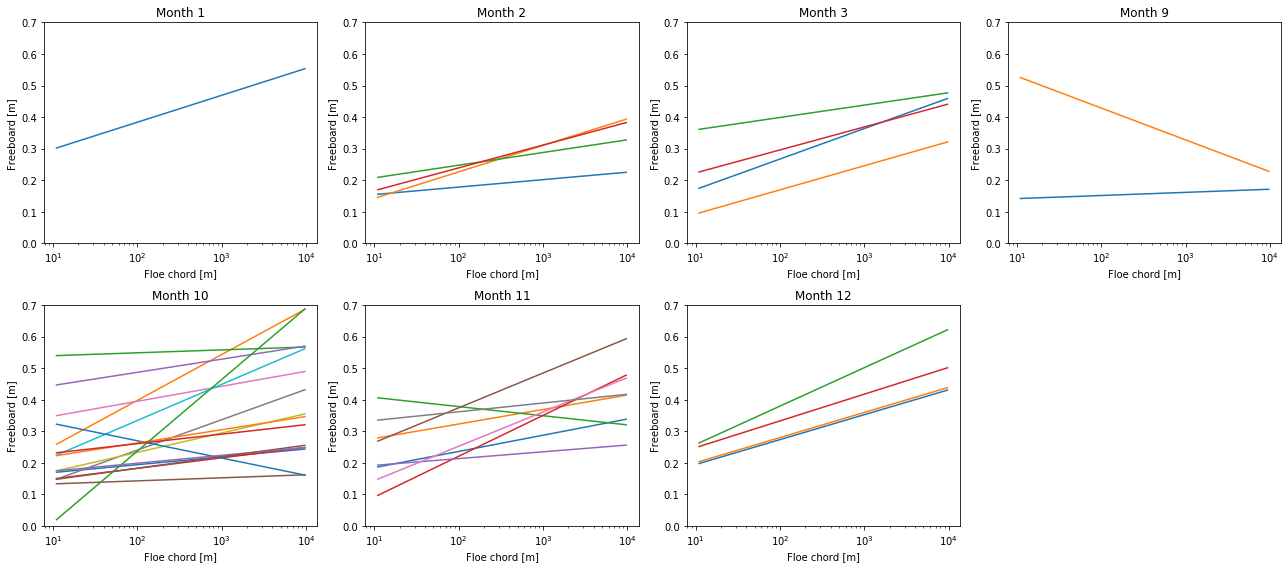

In [9]:
mths_labels = []
mths_unique = np.sort(np.unique(mth_all)) 
nmonths = len(mths_unique)

# fig, ax = plt.subplots(figsize = (15, 15),nrows=4, ncols=2)

fig = plt.figure(figsize = (18, 8))
for i in range(nmonths):
    mth = mths_unique[i]
    idx = np.where(mth_all == mth)[0]
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(floe_chord_bin_means,floe_fb_mean_all[:,idx])
    ax.set_xscale("log")
    plt.ylim((0,0.7))
    plt.xlabel("Floe chord [m]")
    plt.ylabel("Freeboard [m]")
    plt.title("Month "+str(int(mth)))

fig.tight_layout()

Text(0, 0.5, 'Freeboard [m]')

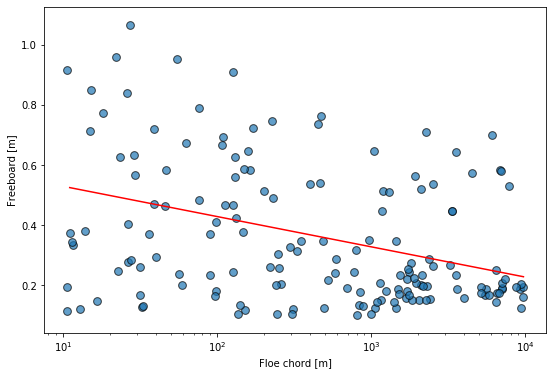

In [10]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(floe_chord_lengths,floe_fb, s=60, alpha=0.7, edgecolors="k")
# ax.scatter(floe_chord_bin_means,floe_fb_means, s=60, alpha=0.7, edgecolors="k")
ax.plot(floe_chord_bin_means,floe_fb_best_fit,color='r')
ax.set_xscale("log");
plt.xlabel("Floe chord [m]")
plt.ylabel("Freeboard [m]")
# plt.ylim((0,0.2))

In [6]:
# # Verifying where the leads are 
# idx_st = 0
# idx_en = len(fb_lat)
# plt.plot(fb_lat[idx_st:idx_en],height_segment_type[idx_st:idx_en])
# # plt.plot(fb_lat[idx_st:idx_en],fb_height[idx_st:idx_en])
# plt.scatter(lead_lat,np.ones(len(lead_lat)))
# plt.xlim((fb_lat[idx_st], fb_lat[idx_en-1]))  